## Lesson 1
* Get data from yfinance
* Get closing prices
* **Normalize** closing prices
* Calculate **daily returns**
* Create histogram of daily returns and measure **kurtosis**
* Calculate **bollinger bands**
* Create scatterplot of daily returns with a stock on x and another stock on y axis
* **Cumulative return** based on portfolio allocation
* Function to calculate sharpe, cumulative return, volatility, and average daily return given a portfolio allocation

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

def get_ticker_data(ticker_symbols,start_date,end_date):
    ticker_data_dict = {}
    for ticker in ticker_symbols:
        #get data on this ticker
        tickerData = yf.Ticker(ticker)

        #get the historical prices for this ticker
        tickerDf = tickerData.history(period='1d', start=start_date, end=end_date)

        #see your data
        ticker_data_dict[ticker] = tickerDf
    return ticker_data_dict

# expects columns to be ticker, data to be closing prices 
def plot_data(df,title):
    df.plot()
    plt.grid()
    plt.title(title)
    plt.autoscale(enable=True, axis='x', tight=True)

# Normalized
def normalize_df(df):
    return df/df.iloc[0,:]

def get_closing_prices(df,normalized=True):
    # Get closing prices DF
    closing_prices = pd.DataFrame()
    for ticker in df:
        closing_prices[ticker] = df[ticker]["Close"]
    if normalized:
        return normalize_df(closing_prices)
    return closing_prices

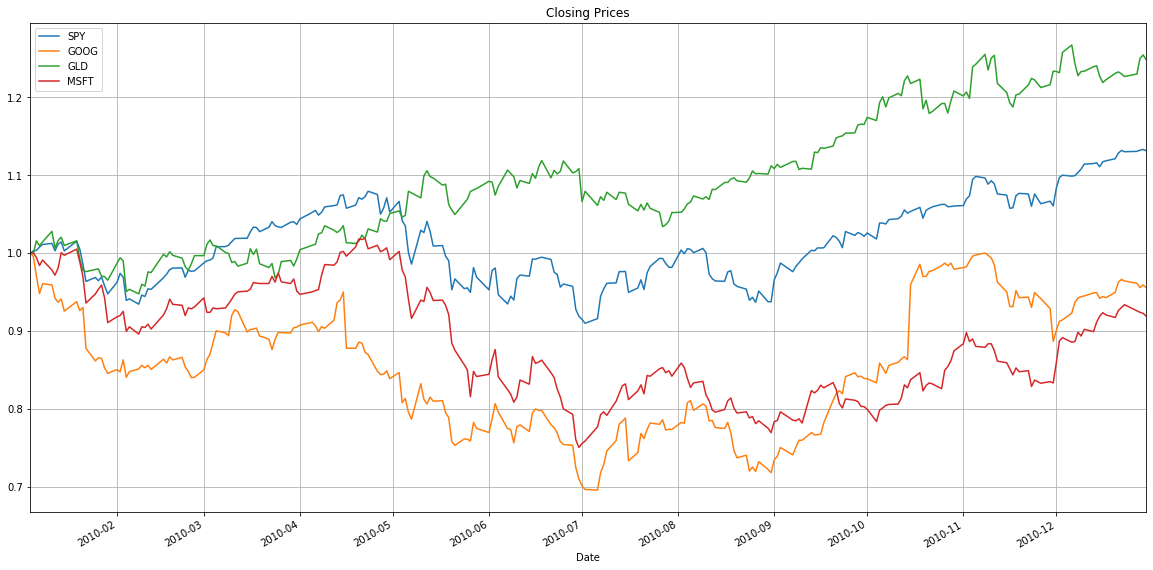

In [2]:

#define the ticker symbol
ticker_symbols = ["SPY","GOOG","GLD","MSFT"]

# Index dates
start_date = "2010-01-01"
end_date = "2010-12-31"

ticker_data = get_ticker_data(ticker_symbols,start_date,end_date)

# Get closing prices DF
closing_prices = get_closing_prices(ticker_data)

plot_data(closing_prices,"Closing Prices")

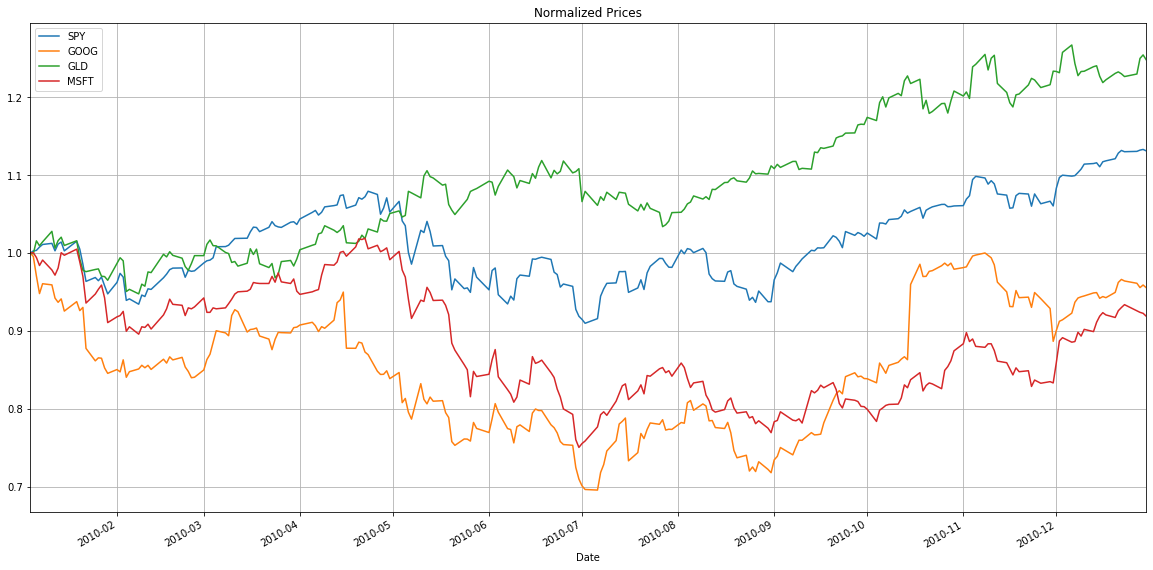

In [3]:
normalized_prices = normalize_df(closing_prices)
plot_data(normalized_prices,"Normalized Prices")

In [4]:
# Computes daily returns for dataframe of a single or multiple stocks
def compute_daily_returns(df):
    returns = df.copy()
    # df[1:] gets all but first index
    # df[:-1] gets all but last index
    returns[1:] = (df[1:].values/df[:-1].values) - 1
    returns.iloc[0,:] = 0 # b/c no "previous" data for first day
    return returns

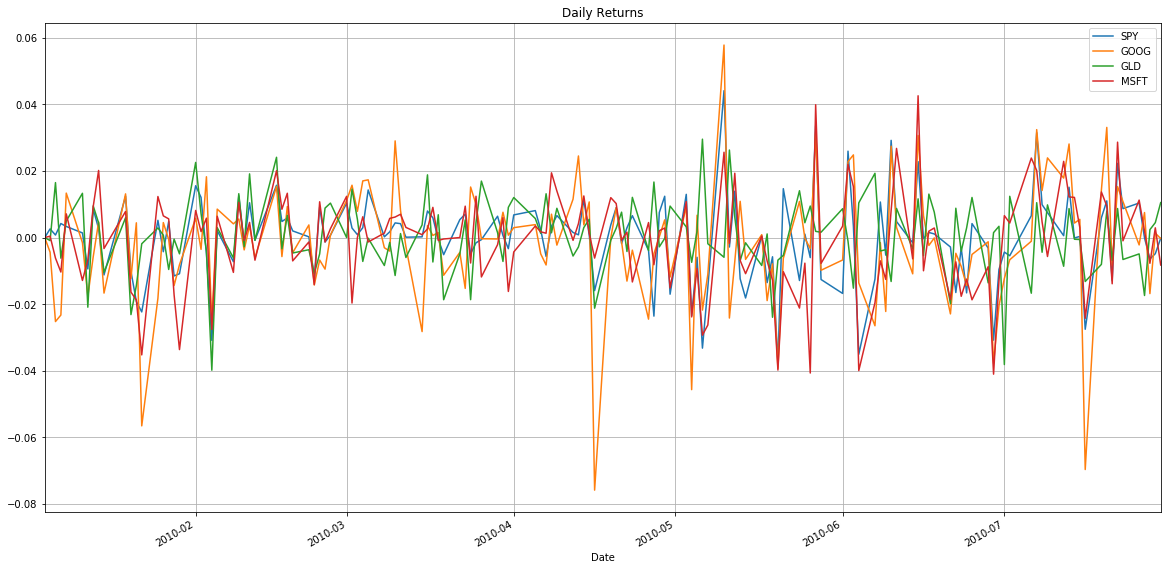

In [5]:
daily_returns = compute_daily_returns(closing_prices)
start = "2010-01-01"
end = "2010-07-31"

def plot_daily_returns(df,title,start,end):
    df[start:end].plot()
    plt.title(title)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.grid()
    
plot_daily_returns(daily_returns,"Daily Returns",start,end)

In [6]:
# Plot histogram and calculate kurtosis
def plot_hist(df):
    df.plot.hist(bins=50)
    kurtosis=df.kurtosis()
    plt.title("{} daily return histogram. Kurtosis={:.2f}".format(ticker,kurtosis))
    plt.show()

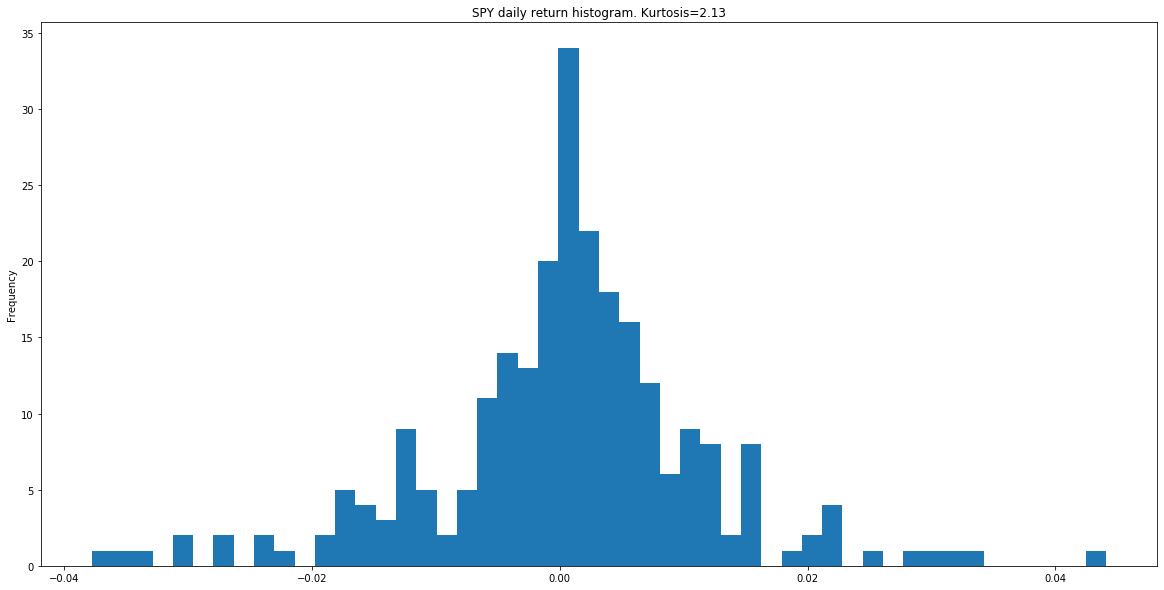

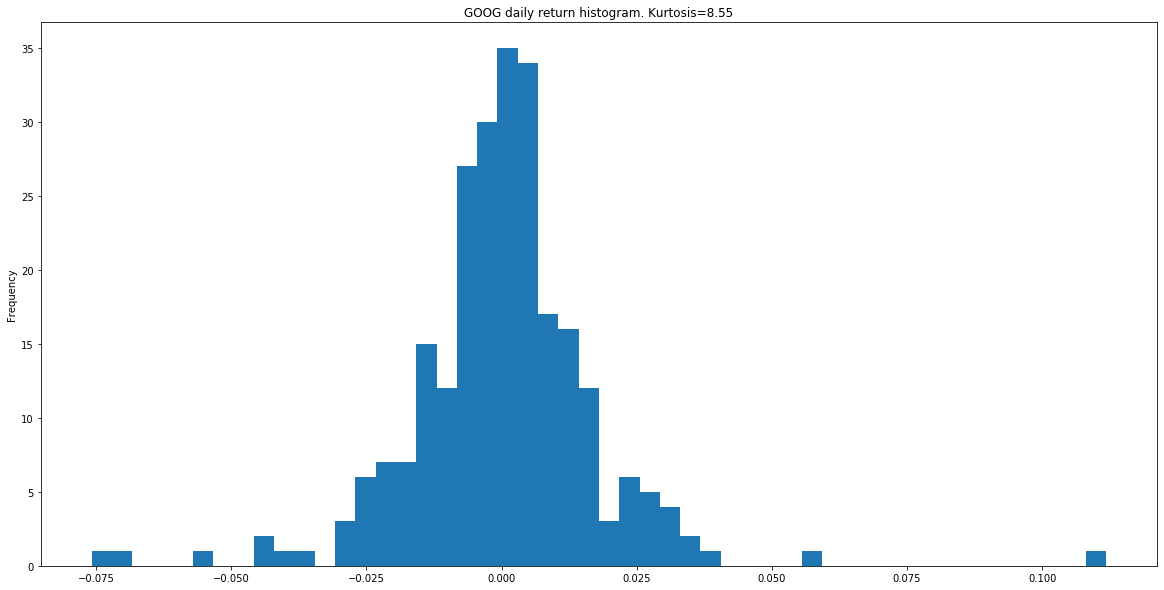

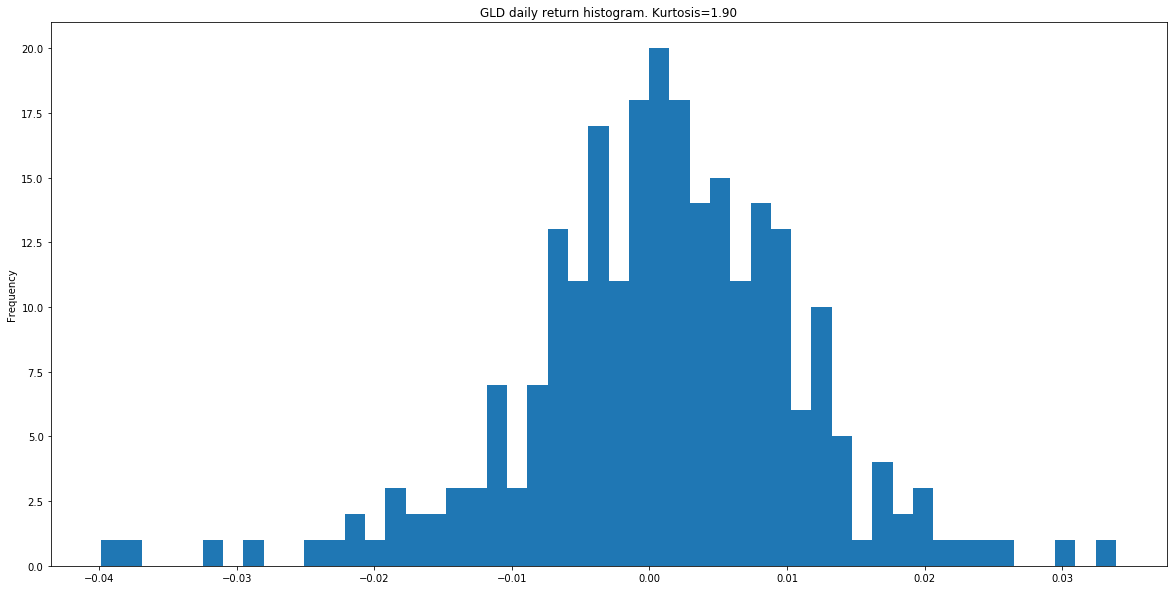

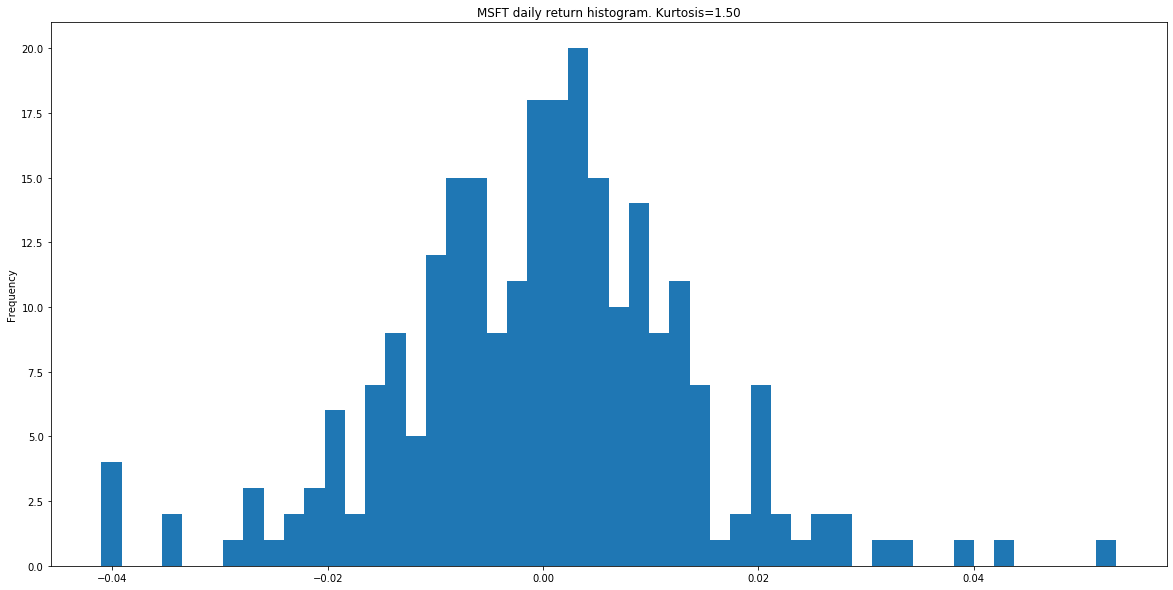

In [7]:
for ticker in ticker_symbols:
    plot_hist(daily_returns[ticker])


In [8]:
# Returns upper and lower bands, and rolling mean
def calculate_bollinger_bands(df):
    rolling_windows = df.rolling(20, min_periods=20)
    rolling_mean = rolling_windows.mean().dropna()
    rolling_std = rolling_windows.std().dropna()
    upper = rolling_mean + (2 * rolling_std)
    lower = rolling_mean - (2 * rolling_std)
    return upper,lower,rolling_mean

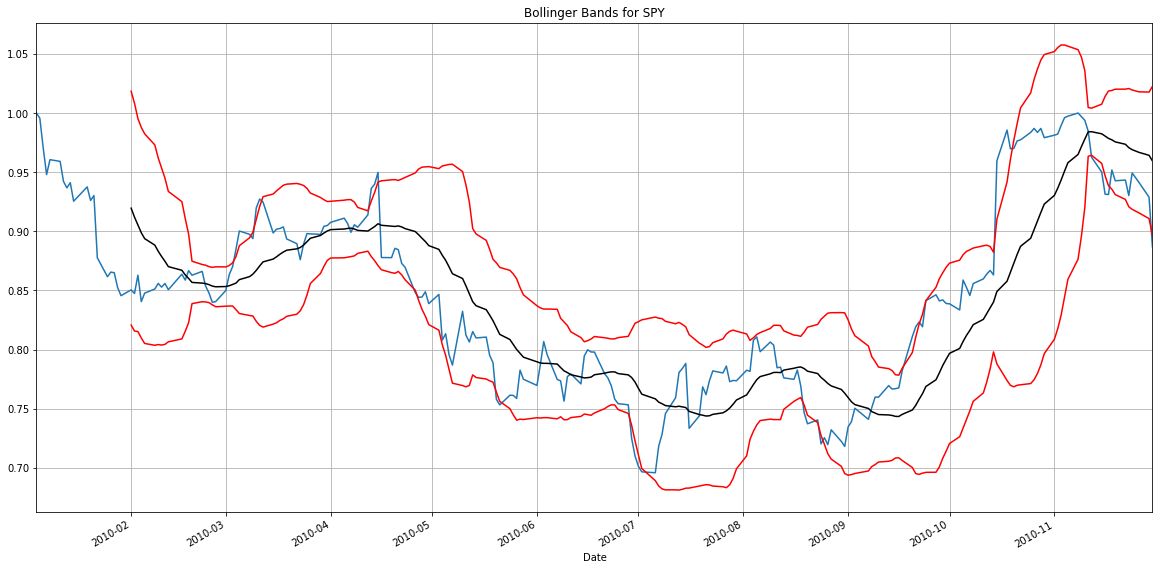

In [19]:
start = "2010-01-01"
end = "2010-11-30"

current_data = normalized_prices["GOOG"][start:end]
bollinger_bands = calculate_bollinger_bands(current_data)

def plot_bollinger(data,bands,title):
    data.plot()
    upper,lower,rm = bands
    
    upper.plot(color="r")
    lower.plot(color="r")
    rm.plot(color="k")
    
    plt.title(title)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.grid()
    plt.show()

plot_bollinger(current_data,bollinger_bands,"Bollinger Bands for SPY")

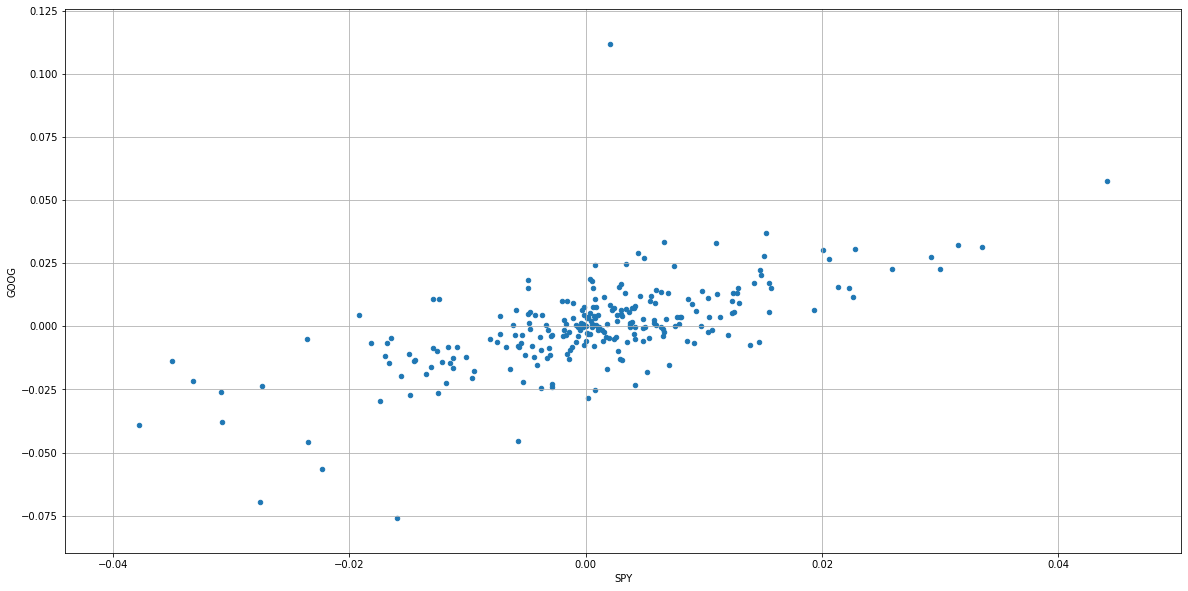

In [20]:
daily_returns.plot(kind="scatter",x="SPY",y="GOOG")
plt.grid()

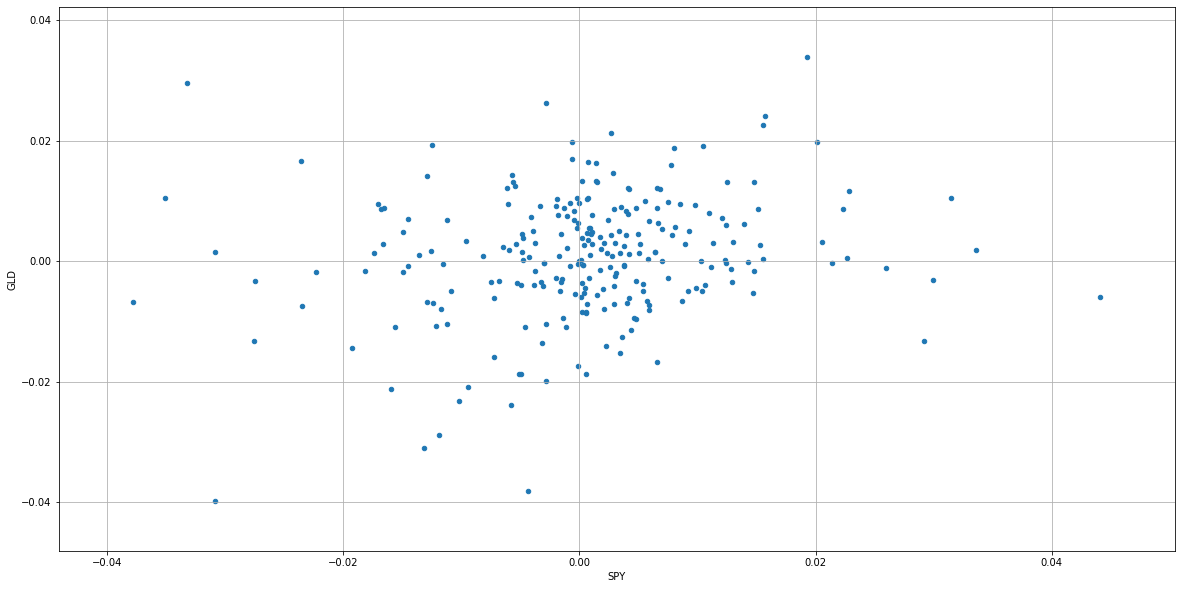

In [21]:
daily_returns.plot(kind="scatter",x="SPY",y="GLD")
plt.grid()

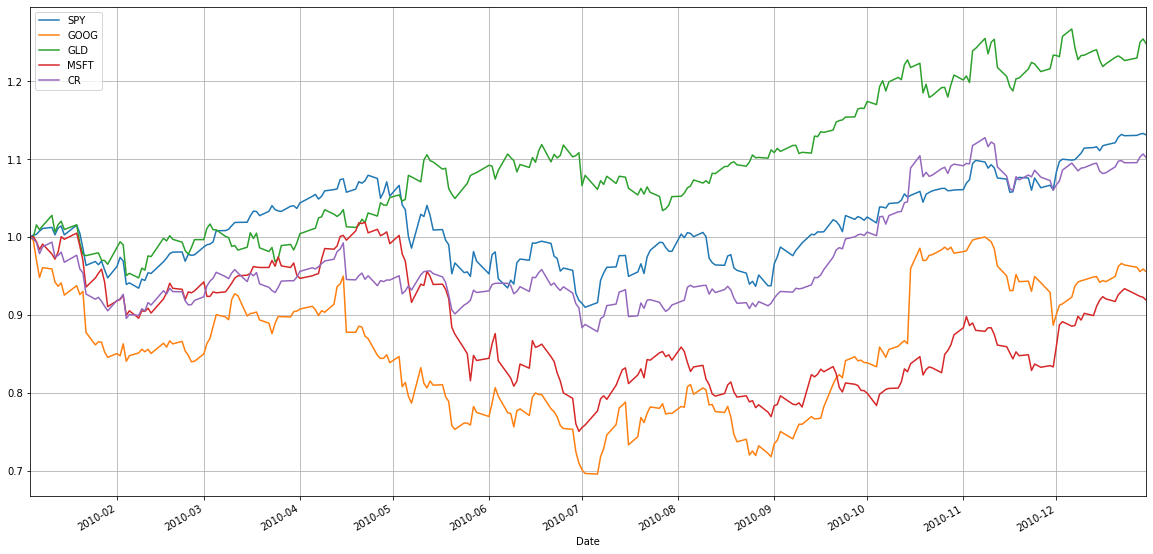

In [22]:
def compute_cumulative_return(df,allocations):
    cr = df.dot(allocations).rename("CR") # Need to add name to Series
    return df.join(cr)

portfolio_returns = compute_cumulative_return(normalized_prices,[0,0.5,0.5,0]) 
portfolio_returns.plot()
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()

In [23]:
def compute_sharpe_ratio(daily_returns,K=252):
    import math
    mean_daily = daily_returns.mean(axis=0) # Portfolio returns
    std_daily = daily_returns.std(axis=0) # Portfolio std
    sr = math.sqrt(K) * ((mean_daily) / std_daily)
    return sr

compute_sharpe_ratio(compute_daily_returns(portfolio_returns))

SPY     0.780434
GOOG   -0.025308
GLD     1.432988
MSFT   -0.276804
CR      0.687525
dtype: float64

In [24]:

def get_cumulative_return(df):
    return df["CR"][-1] - df["CR"][0]

# Input: tickers, portfolio allocation, start date, end date
# Output: Cumulative return, Sharpe Ratio, Volatility, Average daily return
def assess_portfolio(tickers,allocations,start_date,end_date,plot=False):
    closing_prices = get_closing_prices(get_ticker_data(tickers,start_date,end_date),normalized=True)
    cumulative_returns = compute_cumulative_return(closing_prices,allocations)
    daily_returns = compute_daily_returns(cumulative_returns)
    sharpe_ratios = compute_sharpe_ratio(daily_returns)
    cr = get_cumulative_return(cumulative_returns)

    print("Sharpe Ratio: {}".format(sharpe_ratios["CR"]))
    print("Volatility (daily std): {}".format(daily_returns["CR"].std()))
    print("Average Daily Return: {}".format(daily_returns["CR"].mean()))
    print("Cumulative Return: {}".format(cr))

    if plot:
        spy = get_closing_prices(get_ticker_data(["SPY"],start_date,end_date),normalized=True)
        data = spy.join(cumulative_returns["CR"])
        plot_data(data,"SPY and Portfolio returns")

Sharpe Ratio: 1.5050182618716585
Volatility (daily std): 0.01000871207937215
Average Daily Return: 0.0009488983585541794
Cumulative Return: 0.2529888680119141


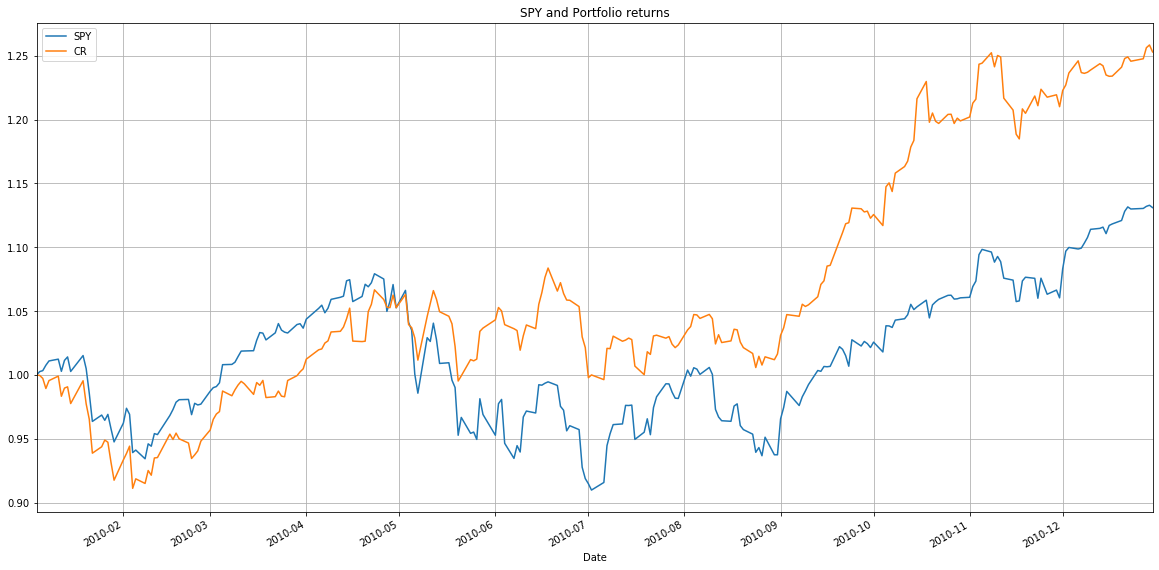

In [30]:
import datetime as dt
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2010,12,31)
tickers = ['GOOG', 'AAPL', 'GLD', 'XOM']
alloc = [0.2, 0.3, 0.4, 0.1]

assess_portfolio(tickers,alloc,start_date,end_date,plot=True)

Sharpe Ratio: 1.033231597380156
Volatility (daily std): 0.009371706392004298
Average Daily Return: 0.0006099806839424213
Cumulative Return: 0.1526610644257702


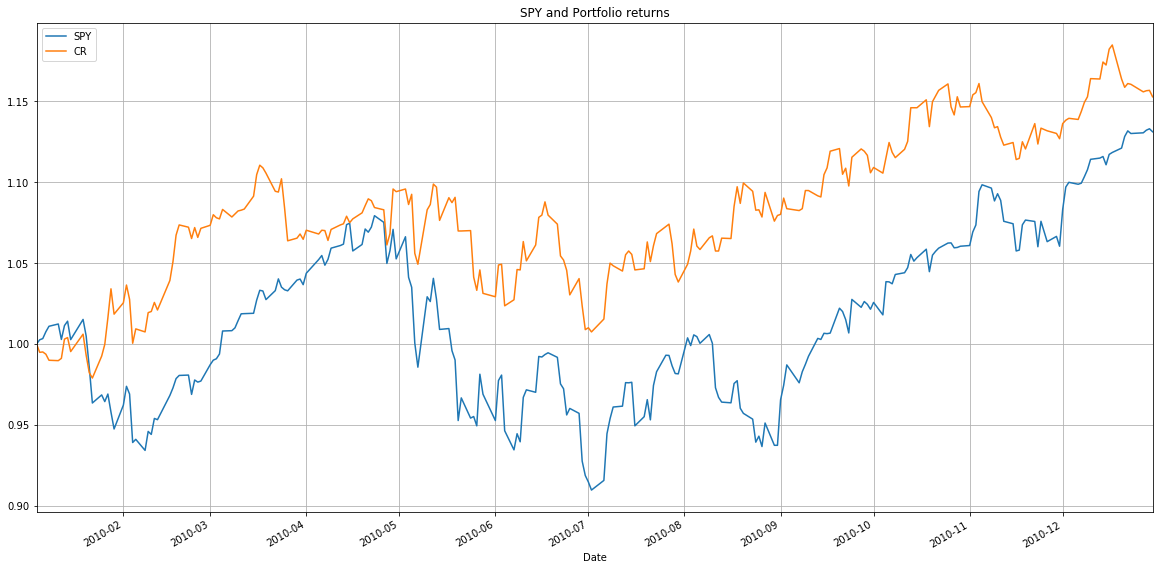

In [31]:
start_date = dt.datetime(2010,1,1)
end_date = dt.datetime(2010,12,31)
tickers = ['AXP', 'HPQ', 'IBM', 'HNZ']
alloc = [0.0, 0.0, 0.0, 1.0]

assess_portfolio(tickers,alloc,start_date,end_date,plot=True)

Sharpe Ratio: 2.1942936740232266
Volatility (daily std): 0.00930014863233679
Average Daily Return: 0.0012855363758786133
Cumulative Return: 0.20325789110469006


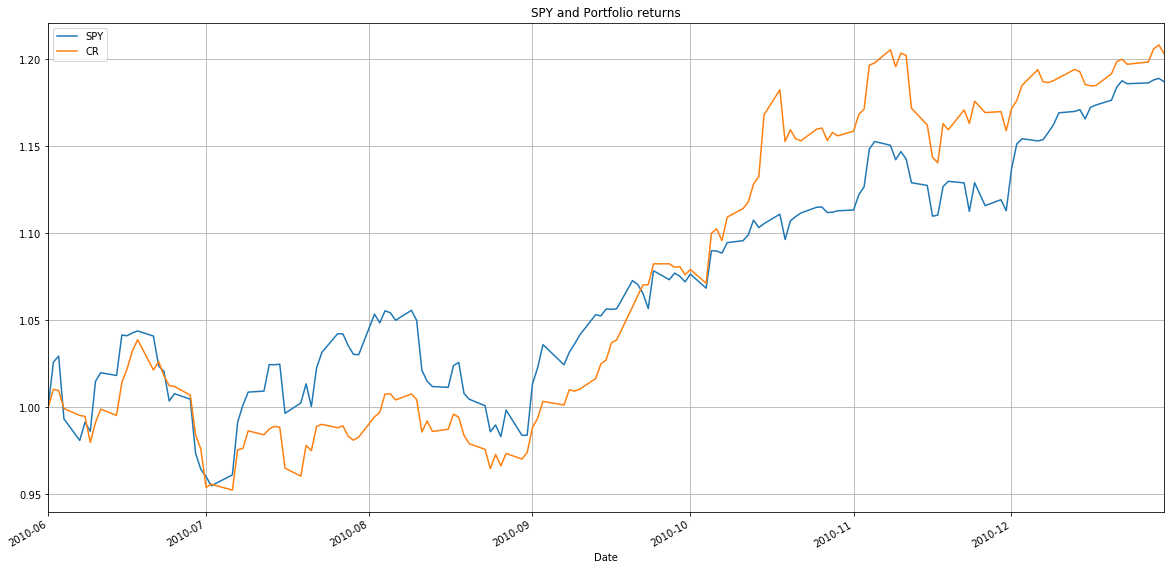

In [32]:
start_date = dt.datetime(2010,6,1)
end_date = dt.datetime(2010,12,31)
tickers = ['GOOG', 'AAPL', 'GLD', 'XOM']
alloc = [0.2, 0.3, 0.4, 0.1]
assess_portfolio(tickers,alloc,start_date,end_date,plot=True)